Training an EMNIST classifier

EMNIST (or extended MNIST) is just like MNIST, a bunch of handwritten images, except instead of just digits (0-9) it also has uppercase and lowercase characters.



In [2]:
from IPython.display import clear_output

In [3]:
%pip install torch torchvision
%pip install matplotlib

clear_output()

In [4]:
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torchvision.datasets import EMNIST
import torchvision.transforms.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch import optim
from torchvision.transforms.functional import to_tensor
import matplotlib.pyplot as plt


In [5]:
train_data = EMNIST(root='emnist_data/', split='byclass', download=True,transform=to_tensor)
test_data = EMNIST(root='emnist_data/', split='byclass', download=True, train=False,transform=to_tensor)

100%|██████████| 561753746/561753746 [00:09<00:00, 60336603.93it/s]


Extracting emnist_data/EMNIST/raw/gzip.zip to emnist_data/EMNIST/raw


In [6]:
# This cell is for demo purposes. feel free to remove it if you want.
print('Number of classes in dataset:', len(train_data.classes))
print('Unique labels:', train_data.classes)

demo_img, demo_label = train_data[10]

print(demo_label)
F.resize(demo_img, (256, 256)) #resizing just for display

Number of classes in dataset: 62
Unique labels: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
7


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [7]:
from torch.optim import Adam


In [8]:
batch_size = 200

train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [9]:
class NN1Layer(nn.Module):

  def __init__(self, num_inp, num_out):

    super(NN1Layer, self).__init__()

    self.layer_1 = nn.Linear(num_inp, num_out)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):

    z = self.layer_1(x)
    a = self.softmax(z)

    return a



class NN2Layer(nn.Module):

  def __init__(self, num_inp, num_hidden, num_out):

    super(NN2Layer, self).__init__()

    self.layer_1 = nn.Linear(num_inp, num_hidden)
    self.layer_2 = nn.Linear(num_hidden, num_out)

    self.hidden_activation = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):

    z1 = self.layer_1(x)
    a1 = self.hidden_activation(z1)

    z2 = self.layer_2(a1)
    a2 = self.softmax(z2)

    return a2

In [10]:
# increase the number of epoches for a better model (it is going to take some time)
num_epochs = 50
lr = 1e-4

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_losses = []
val_losses = []

model = NN2Layer(28*28,128, 62)
optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

model.to(device)

print(f'Using device {device}')

Using device cpu


In [11]:
model.eval()
correctly_labelled = 0

with torch.no_grad():

  val_epoch_weighted_loss = 0

  for val_batch_X, val_batch_y in test_loader:

    val_batch_X = val_batch_X.view(-1, 28*28).to(device)
    val_batch_y = val_batch_y.to(device)

    val_batch_y_probs = model(val_batch_X)
    loss = criterion(val_batch_y_probs, val_batch_y)
    val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

    val_batch_y_pred = val_batch_y_probs.argmax(dim=1)

    correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()

val_epoch_loss = val_epoch_weighted_loss/len(test_loader.dataset)
val_losses.append(val_epoch_loss)

print(f'val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)')


val_loss=4.127206264562847. labelled 2466/116323 correctly (2.1199590794597802% accuracy)


In [12]:
for epoch_no in range(num_epochs):

  model.train()  # convert to train model. This turns out train-specific layers in the model (if you dont know about them, an example of them is dropout. more on this later)

  epoch_weighted_loss = 0

  for batch_X, batch_y in train_loader:

    batch_X = batch_X.view(-1, 28*28).to(device)  # convert to [N, 28*28] shape where N is batch_size
    batch_y = batch_y.to(device)

    batch_y_probs = model(batch_X)  # outputs [N, 10] where each [:, 10] is probabilities for class (0-9)

    loss = criterion(batch_y_probs, batch_y)

    optimizer.zero_grad()  # need to clear out gradients from previous batch
    loss.backward()  # calculate new gradients
    optimizer.step()  # update weights

    epoch_weighted_loss += (len(batch_y)*loss.item())

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
  train_losses.append(epoch_loss)



  model.eval()
  correctly_labelled = 0

  with torch.no_grad():

    val_epoch_weighted_loss = 0

    for val_batch_X, val_batch_y in test_loader:

      val_batch_X = val_batch_X.view(-1, 28*28).to(device)
      val_batch_y = val_batch_y.to(device)

      val_batch_y_probs = model(val_batch_X)

      loss = criterion(val_batch_y_probs, val_batch_y)
      val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

      val_batch_y_pred = val_batch_y_probs.argmax(dim=1)

      correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()

  val_epoch_loss = val_epoch_weighted_loss/len(test_loader.dataset)
  val_losses.append(val_epoch_loss)

  print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(test_loader.dataset)} correctly ({correctly_labelled/len(test_loader.dataset)*100}% accuracy)')

print(f'Training complete on device {device}. Change device variable and run again to see the difference.')

Epoch: 0, train_loss=3.7702191342601488, val_loss=3.7054076405854106. labelled 52981/116323 correctly (45.546452550226526% accuracy)
Epoch: 1, train_loss=3.700213656414517, val_loss=3.68524911980974. labelled 55067/116323 correctly (47.33973504809883% accuracy)
Epoch: 2, train_loss=3.681680398129392, val_loss=3.6711321230820047. labelled 56783/116323 correctly (48.81493771653069% accuracy)
Epoch: 3, train_loss=3.6693918330831066, val_loss=3.6639127147999844. labelled 57483/116323 correctly (49.416710366823416% accuracy)
Epoch: 4, train_loss=3.654639768035309, val_loss=3.6469515994067296. labelled 59458/116323 correctly (51.114568915863586% accuracy)
Epoch: 5, train_loss=3.646435881509836, val_loss=3.6424565532424893. labelled 59913/116323 correctly (51.50572113855385% accuracy)
Epoch: 6, train_loss=3.642358590803059, val_loss=3.638191778002731. labelled 60412/116323 correctly (51.934699070691096% accuracy)
Epoch: 7, train_loss=3.6389669482081595, val_loss=3.6356198379875235. labelled 6

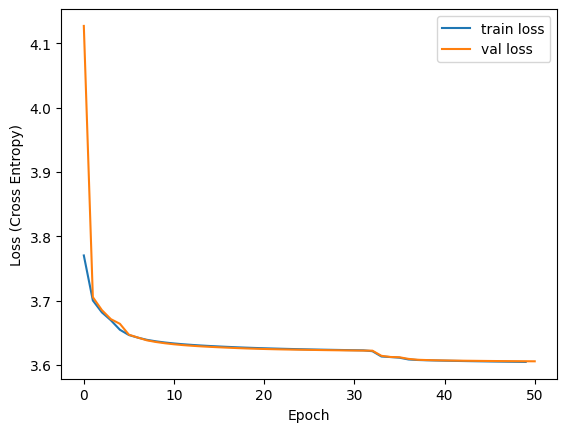

In [13]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Cross Entropy)')
plt.legend()
plt.show()

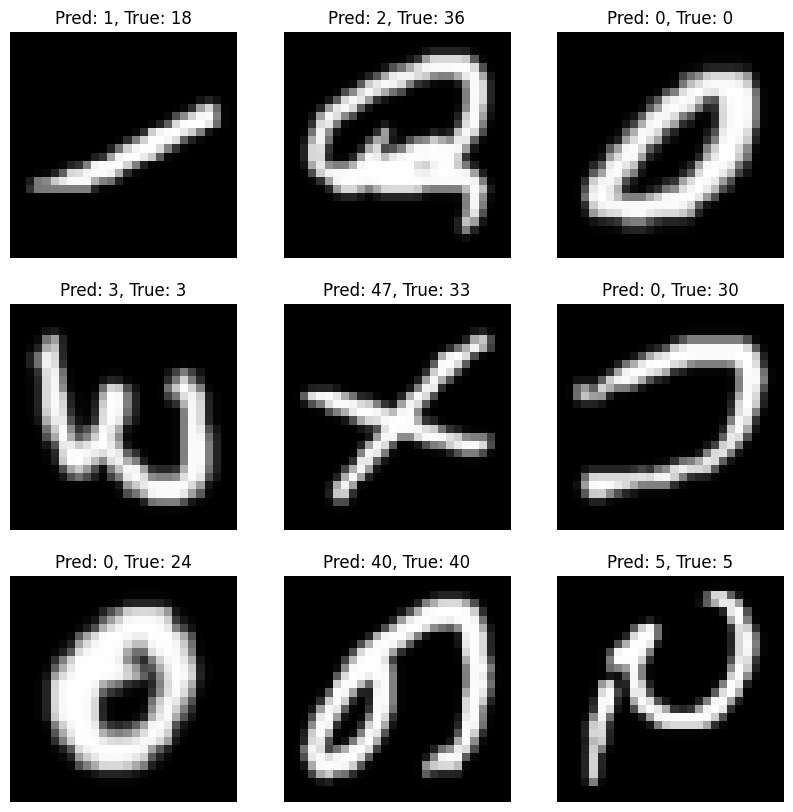

In [14]:
# Plot some predictions
model.eval()
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

with torch.no_grad():
    for i, (img, label) in enumerate(test_data):
        if i == 9:
            break
        ax = axes[i//3, i%3]
        img = img.view(1, 28*28).to(device)
        output = model(img)
        _, pred = torch.max(output, 1)
        ax.imshow(img.cpu().view(28, 28), cmap='gray')
        ax.set_title(f'Pred: {pred.item()}, True: {label}')
        ax.axis('off')

plt.show()